Product : https://www.sec.gov/Archives/edgar/data/927971/000121465922011753/b930221424b2.htm

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as st
import matplotlib.pyplot as plt
from datetime import date, timedelta

In [2]:
# important dates
pricing_date = date(2022, 9, 28)
valuation_date = date(2023, 10, 31)
maturity_date = date(2023, 11, 3)
T = (valuation_date - pricing_date).days / 365

# cpn payment dates
T1 = date(2022, 11, 3)
T2 = date(2022, 12, 3)
T3 = date(2023, 1, 3)
T4 = date(2023, 2, 3)
T5 = date(2023, 3, 3)
T6 = date(2023, 4, 3)
T7 = date(2023, 5, 3)
T8 = date(2023, 6, 3)
T9 = date(2023, 7, 3)
T10 = date(2023, 8, 3)
T11 = date(2023, 9, 3)
T12 = date(2023, 10, 3)
T13 = date(2023, 11, 3)

# convert into a list of observation dates (cpn date - 3) in terms of tau
observation_dates = [T1, T2, T3, T4, T5, T6, T7, T8, T9, T10, T11, T12, T13]
observation_dates = [(each - timedelta(3) - pricing_date).days / 365 for each in observation_dates]

In [11]:
# initial index and barrier levels
S0 = 3719.04
barrier = 2789.28

# principal and coupon amount
face = 1000
cpn = face * 0.00967

## From Bloomberg
# linear interpretation for interest rate
discount_factor = ((date(2024, 3, 28) - valuation_date).days * 0.956950 + \
                  (valuation_date - date(2023, 9, 28)).days * 0.935338) / \
                  (date(2024, 3, 28) - date(2023, 9, 28)).days 

r = -np.log(discount_factor) / T # 0.04411867760465754

# annual dividend yield of underlying
q = 0.01845

# volatility
sigma = 0.28936
sigmas = [0.27405, 0.26391, 0.26169, 0.25832, 0.25945, # moneyness 100
          0.26106, 0.26036, 0.26044, 0.26009, 0.25908, 
          0.25898, 0.25940, 0.25864,
          0.49656, 0.42627, 0.40022, 0.38375, 0.37344, # moneyness 75
          0.36613, 0.35772, 0.35208, 0.34697, 0.34211, 
          0.33800, 0.33492, 0.33074]

# set 5174 time step (13 steps a day) so that coupon dates fall on integer steps
imax = (valuation_date - pricing_date).days * 13

# upper boundary index level
SU = 2.5 * S0

In [4]:
# Crank-Nicolson Method
def CNFD(sigma, jmaxmin, jmaxmax, jmaxstep): # setting grid

    result = []

    for jmax in range(jmaxmin, jmaxmax, jmaxstep):

    # get deltas
        dt = T / imax
        dS = SU / jmax

    # set barriers
        j0 = int(S0 / dS)
        if j0 * dS < S0:
            j0 = j0 + 1
            
        jb = int(barrier / dS)

    # get observation dates in terms of time step
        obs_dates = [int(each/dt) for each in observation_dates]
        

##### VT grid (if trigger event happens)
#############################################################################################
    # initialize VT grid
        VT = np.zeros([imax+1, jmax+1])
        A = np.zeros([jmax+1])
        B = np.zeros([jmax+1])
        C = np.zeros([jmax+1])
        D = np.zeros([jmax+1])
        alpha = np.zeros([jmax+1])
        CN_S = np.zeros([jmax+1])
    
    # payment at maturity
        i = imax
        for j in range(jmax+1):
            if j >= j0:
                VT[i, j] = np.exp(-r * 3/365) * (face + cpn)
            elif j < j0 and j >= jb:
                VT[i, j] = np.exp(-r * 3/365) * (face * (j*dS / S0) + cpn)
            else:
                VT[i, j] = np.exp(-r * 3/365) * (face * (j*dS / S0))

    # calculate grid back to t = 3/29/2023 (when autocall starts)
        for i in range(imax-1, obs_dates[5]-1, -1):
            
        # if on observation date
            if i in obs_dates:
            
            # value above callable boundary
                for j in range(j0, jmax):
                    VT[i, j] = np.exp(-r * 3/365) * (face + cpn)

            ## get A, B, C, and D for Crank-Nicolson method  
            # set lower boundary
                A[0] = 0
                B[0] = 1
                C[0] = 0
                D[0] = 0

                for j in range(1, j0):
                    A[j] = 0.25*sigma**2*j**2 - 0.25*(r-q)*j
                    B[j] = -1/dt - 0.5*r - 0.5*sigma**2*j**2
                    C[j] = 0.25*sigma**2*j**2 + 0.25*(r-q)*j
                    D1 = -VT[i+1, j-1] * (0.25*sigma**2*j**2 - 0.25*(r-q)*j)
                    D2 = -VT[i+1, j] * (1/dt - 0.5*r - 0.5*sigma**2*j**2)
                    D3 = -VT[i+1, j+1] * (0.25*sigma**2*j**2 + 0.25*(r-q)*j)
                    D[j] = D1 + D2 + D3
            
            # set upper boundary
                A[j0] = 0
                B[j0] = 1
                C[j0] = 0
                D[j0] = (face + cpn) * np.exp(-r * 3/365)

                alpha[0] = B[0]
                CN_S[0] = D[0]
                for j in range(1, j0+1):
                    alpha[j] = B[j] - (A[j]*C[j-1]) / alpha[j-1]
                    CN_S[j] = D[j] - (A[j]*CN_S[j-1]) / alpha[j-1]

                # VT[i, j0] = CN_S[j0] / alpha[j0]
                for j in range(j0-1, -1, -1): 
                    VT[i, j] = (CN_S[j] - C[j]*VT[i, j+1]) / alpha[j]  
            
            # add in coupon 
                for j in range(j0-1, jb-1, -1):
                    VT[i, j] = VT[i, j] + np.exp(-r * 3/365) * cpn
                  

        # on all other dates
            else:

            ## get A, B, C, and D for Crank-Nicolson method  
            # set lower boundary
                A[0] = 0
                B[0] = 1
                C[0] = 0
                D[0] = 0

                for j in range(1, jmax):
                    A[j] = 0.25*sigma**2*j**2 - 0.25*(r-q)*j
                    B[j] = -1/dt - 0.5*r - 0.5*sigma**2*j**2
                    C[j] = 0.25*sigma**2*j**2 + 0.25*(r-q)*j
                    D1 = -VT[i+1, j-1] * (0.25*sigma**2*j**2 - 0.25*(r-q)*j)
                    D2 = -VT[i+1, j] * (1/dt - 0.5*r - 0.5*sigma**2*j**2)
                    D3 = -VT[i+1, j+1] * (0.25*sigma**2*j**2 + 0.25*(r-q)*j)
                    D[j] = D1 + D2 + D3

            # get time of next autocall
                for k in range(len(obs_dates)):
                    if i < obs_dates[k+1] and i > obs_dates[k]:
                        t_next_call = obs_dates[k+1]
                        break
            # set upper boundary
                A[jmax] = 0
                B[jmax] = 1
                C[jmax] = 0
                D[jmax] = (face + cpn) * np.exp(-r * (t_next_call - i) * dt)

                alpha[0] = B[0]
                CN_S[0] = D[0]
                for j in range(1, jmax+1):
                    alpha[j] = B[j] - (A[j]*C[j-1]) / alpha[j-1]
                    CN_S[j] = D[j] - (A[j]*CN_S[j-1]) / alpha[j-1]  

                VT[i, jmax] = CN_S[jmax] / alpha[jmax]
                for j in range(jmax-1, -1, -1):
                    VT[i, j] = (CN_S[j] - C[j]*VT[i, j+1]) / alpha[j]
    
    # calculate grid back to t = 0
        for i in range(obs_dates[5]-1, -1, -1):
            
        # if on observation dates
            if i in obs_dates:
                
            ## get A, B, C, and D for Crank-Nicolson method  
            # set lower boundary
                A[0] = 0
                B[0] = 1
                C[0] = 0
                D[0] = 0

                for j in range(1, jmax):
                    A[j] = 0.25*sigma**2*j**2 - 0.25*(r-q)*j
                    B[j] = -1/dt - 0.5*r - 0.5*sigma**2*j**2
                    C[j] = 0.25*sigma**2*j**2 + 0.25*(r-q)*j
                    D1 = -VT[i+1, j-1] * (0.25*sigma**2*j**2 - 0.25*(r-q)*j)
                    D2 = -VT[i+1, j] * (1/dt - 0.5*r - 0.5*sigma**2*j**2)
                    D3 = -VT[i+1, j+1] * (0.25*sigma**2*j**2 + 0.25*(r-q)*j)
                    D[j] = D1 + D2 + D3

            # set upper boundary
                t_next_call = obs_dates[5] # next autocall date
                A[jmax] = 0
                B[jmax] = 1
                C[jmax] = 0
                D[jmax] = (face + cpn) * np.exp(-r * (t_next_call - i) * dt)

                alpha[0] = B[0]
                CN_S[0] = D[0]
                for j in range(1, jmax+1):
                    alpha[j] = B[j] - (A[j]*C[j-1]) / alpha[j-1]
                    CN_S[j] = D[j] - (A[j]*CN_S[j-1]) / alpha[j-1]

                VT[i, jmax] = CN_S[jmax] / alpha[jmax]
                for j in range(jmax-1, -1, -1): 
                    VT[i, j] = (CN_S[j] - C[j]*VT[i, j+1]) / alpha[j]  
            
            # add in coupon
                for j in range(jmax-1, jb-1, -1):
                    VT[i, j] = VT[i, j] + np.exp(-r * 3/365) * cpn
                

        # on all other dates
            else:

            ## get A, B, C, and D for Crank-Nicolson method  
            # set lower boundary
                A[0] = 0
                B[0] = 1
                C[0] = 0
                D[0] = 0

                for j in range(1, jmax):
                    A[j] = 0.25*sigma**2*j**2 - 0.25*(r-q)*j
                    B[j] = -1/dt - 0.5*r - 0.5*sigma**2*j**2
                    C[j] = 0.25*sigma**2*j**2 + 0.25*(r-q)*j
                    D1 = -VT[i+1, j-1] * (0.25*sigma**2*j**2 - 0.25*(r-q)*j)
                    D2 = -VT[i+1, j] * (1/dt - 0.5*r - 0.5*sigma**2*j**2)
                    D3 = -VT[i+1, j+1] * (0.25*sigma**2*j**2 + 0.25*(r-q)*j)
                    D[j] = D1 + D2 + D3
            
            # set upper boundary
                t_next_call = obs_dates[5]
                A[jmax] = 0
                B[jmax] = 1
                C[jmax] = 0
                D[jmax] = (face + cpn) * np.exp(-r * (t_next_call - i) * dt)

                alpha[0] = B[0]
                CN_S[0] = D[0]
                for j in range(1, jmax+1):
                    alpha[j] = B[j] - (A[j]*C[j-1]) / alpha[j-1]
                    CN_S[j] = D[j] - (A[j]*CN_S[j-1]) / alpha[j-1]  

                VT[i, jmax] = CN_S[jmax] / alpha[jmax]
                for j in range(jmax-1, -1, -1):
                    VT[i, j] = (CN_S[j] - C[j]*VT[i, j+1]) / alpha[j]     


##### V grid (if no trigger event)
#############################################################################################
    
    # initialize V grid    
        V = np.zeros([imax+1, jmax+1])
        A = np.zeros([jmax+1])
        B = np.zeros([jmax+1])
        C = np.zeros([jmax+1])
        D = np.zeros([jmax+1])
        alpha = np.zeros([jmax+1])
        CN_S = np.zeros([jmax+1])

    # payment at maturity
        i = imax
        for j in range(jmax+1):
            if j > jb:
                V[i, j] = np.exp(-r * 3/365) * (face + cpn)
            else:
                V[i, j] = VT[i, j]

    # calculate grid back to t = 3/29/2023 (when autocall starts) 
        for i in range(imax-1, obs_dates[5]-1, -1):

        # if on observation dates
            if i in obs_dates:

            # value above callable boundary
                for j in range(j0, jmax):
                    V[i, j] = np.exp(-r * 3/365) * (face + cpn)

            # fill in the value below jb with value from VT grid
                for j in range(jb+1):
                    V[i, j] = VT[i, j]
                
            ## get A, B, C, and D for Crank-Nicolson method  
            # set lower boundary
                A[jb] = 0
                B[jb] = 1
                C[jb] = 0
                D[jb] = VT[i, jb]

                for j in range(jb+1, j0):
                    A[j] = 0.25*sigma**2*j**2 - 0.25*(r-q)*j
                    B[j] = -1/dt - 0.5*r - 0.5*sigma**2*j**2
                    C[j] = 0.25*sigma**2*j**2 + 0.25*(r-q)*j
                    D1 = -V[i+1, j-1] * (0.25*sigma**2*j**2 - 0.25*(r-q)*j)
                    D2 = -V[i+1, j] * (1/dt - 0.5*r - 0.5*sigma**2*j**2)
                    D3 = -V[i+1, j+1] * (0.25*sigma**2*j**2 + 0.25*(r-q)*j)
                    D[j] = D1 + D2 + D3

            # set upper boundary
                A[j0] = 0
                B[j0] = 1
                C[j0] = 0
                D[j0] = (face + cpn) * np.exp(-r * 3/365)

                alpha[jb] = B[jb]
                CN_S[jb] = D[jb]
                for j in range(jb+1, j0+1):
                    alpha[j] = B[j] - (A[j]*C[j-1]) / alpha[j-1]
                    CN_S[j] = D[j] - (A[j]*CN_S[j-1]) / alpha[j-1]

                # V[i, j0] = CN_S[j0] / alpha[j0]
                for j in range(j0-1, jb, -1): 
                    V[i, j] = (CN_S[j] - C[j]*V[i, j+1]) / alpha[j]  
                
            # add in coupon
                for j in range(j0-1, jb, -1):
                    V[i, j] = V[i, j] + np.exp(-r * 3/365) * cpn
                  

        # on all other dates
            else:
                
            # fill in the value below jb with value from VT grid
                for j in range(jb+1):
                    V[i, j] = VT[i, j]

            ## get A, B, C, and D for Crank-Nicolson method  
            # set lower boundary
                A[jb] = 0
                B[jb] = 1
                C[jb] = 0
                D[jb] = VT[i, jb]

                for j in range(jb+1, jmax):
                    A[j] = 0.25*sigma**2*j**2 - 0.25*(r-q)*j
                    B[j] = -1/dt - 0.5*r - 0.5*sigma**2*j**2
                    C[j] = 0.25*sigma**2*j**2 + 0.25*(r-q)*j
                    D1 = -V[i+1, j-1] * (0.25*sigma**2*j**2 - 0.25*(r-q)*j)
                    D2 = -V[i+1, j] * (1/dt - 0.5*r - 0.5*sigma**2*j**2)
                    D3 = -V[i+1, j+1] * (0.25*sigma**2*j**2 + 0.25*(r-q)*j)
                    D[j] = D1 + D2 + D3

            # get time of next autocall
                for k in range(len(obs_dates)):
                    if i < obs_dates[k+1] and i > obs_dates[k]:
                        t_next_call = obs_dates[k+1]
                        break
            
            # set upper boundary
                A[jmax] = 0
                B[jmax] = 1
                C[jmax] = 0
                D[jmax] = (face + cpn) * np.exp(-r * (t_next_call - i) * dt)

                alpha[jb] = B[jb]
                CN_S[jb] = D[jb]
                for j in range(jb+1, jmax+1):
                    alpha[j] = B[j] - (A[j]*C[j-1]) / alpha[j-1]
                    CN_S[j] = D[j] - (A[j]*CN_S[j-1]) / alpha[j-1]  

                V[i, jmax] = CN_S[jmax] / alpha[jmax]
                for j in range(jmax-1, jb, -1):
                    V[i, j] = (CN_S[j] - C[j]*V[i, j+1]) / alpha[j]
    
    # calculate grid back to t = 0
        for i in range(obs_dates[5]-1, -1, -1):
            
        # if on observation dates
            if i in obs_dates:
                
            # fill in the value below jb with value from VT grid
                for j in range(jb+1):
                    V[i, j] = VT[i, j]

            ## get A, B, C, and D for Crank-Nicolson method  
            # set lower boundary
                A[jb] = 0
                B[jb] = 1
                C[jb] = 0
                D[jb] = VT[j, jb]

                for j in range(jb+1, jmax):
                    A[j] = 0.25*sigma**2*j**2 - 0.25*(r-q)*j
                    B[j] = -1/dt - 0.5*r - 0.5*sigma**2*j**2
                    C[j] = 0.25*sigma**2*j**2 + 0.25*(r-q)*j
                    D1 = -V[i+1, j-1] * (0.25*sigma**2*j**2 - 0.25*(r-q)*j)
                    D2 = -V[i+1, j] * (1/dt - 0.5*r - 0.5*sigma**2*j**2)
                    D3 = -V[i+1, j+1] * (0.25*sigma**2*j**2 + 0.25*(r-q)*j)
                    D[j] = D1 + D2 + D3

            # set upper boundary
                t_next_call = obs_dates[5]
                A[jmax] = 0
                B[jmax] = 1
                C[jmax] = 0
                D[jmax] = (face + cpn) * np.exp(-r * (t_next_call - i) * dt)

                alpha[jb] = B[jb]
                CN_S[jb] = D[jb]
                for j in range(jb+1, jmax+1):
                    alpha[j] = B[j] - (A[j]*C[j-1]) / alpha[j-1]
                    CN_S[j] = D[j] - (A[j]*CN_S[j-1]) / alpha[j-1]

                V[i, jmax] = CN_S[jmax] / alpha[jmax]
                for j in range(jmax-1, jb, -1): 
                    V[i, j] = (CN_S[j] - C[j]*V[i, j+1]) / alpha[j]  
                
            # add in coupon
                for j in range(jmax-1, jb, -1):
                    V[i, j] = V[i, j] + np.exp(-r * 3/365) * cpn
                

        # on all other dates
            else:

            # fill in the value below jb with value from VT grid
                for j in range(jb+1):
                    V[i, j] = VT[i, j]
            
            ## get A, B, C, and D for Crank-Nicolson method  
            # set lower boundary
                A[jb] = 0
                B[jb] = 1
                C[jb] = 0
                D[jb] = VT[i, jb]

                for j in range(jb+1, jmax):
                    A[j] = 0.25*sigma**2*j**2 - 0.25*(r-q)*j
                    B[j] = -1/dt - 0.5*r - 0.5*sigma**2*j**2
                    C[j] = 0.25*sigma**2*j**2 + 0.25*(r-q)*j
                    D1 = -V[i+1, j-1] * (0.25*sigma**2*j**2 - 0.25*(r-q)*j)
                    D2 = -V[i+1, j] * (1/dt - 0.5*r - 0.5*sigma**2*j**2)
                    D3 = -V[i+1, j+1] * (0.25*sigma**2*j**2 + 0.25*(r-q)*j)
                    D[j] = D1 + D2 + D3

            # set upper boundary
                t_next_call = obs_dates[5]
                A[jmax] = 0
                B[jmax] = 1
                C[jmax] = 0
                D[jmax] = (face + cpn) * np.exp(-r * (t_next_call - i) * dt)

                alpha[jb] = B[jb]
                CN_S[jb] = D[jb]
                for j in range(jb+1, jmax+1):
                    alpha[j] = B[j] - (A[j]*C[j-1]) / alpha[j-1]
                    CN_S[j] = D[j] - (A[j]*CN_S[j-1]) / alpha[j-1]  

                V[i, jmax] = CN_S[jmax] / alpha[jmax]
                for j in range(jmax-1, jb, -1):
                    V[i, j] = (CN_S[j] - C[j]*V[i, j+1]) / alpha[j]

    # estimated value of product
        Vcrit = V[0, j0]+ (S0 - j0 * dS) / (dS) * (V[0, j0+1] - V[0, j0])
    # barrier lambda
        Blambda = round((barrier - jb*dS) / dS, 2)
    # appending the results
        output = {'S_steps': jmax, 't_steps': imax, 'CN': Vcrit, 'Barrier Lambda': Blambda, 'Sigma': sigma}
        result.append(output)
        
    return result

In [12]:
result = CNFD(sigma, 50, 501, 50)
result_df = pd.DataFrame.from_dict(result)
result_df.to_csv('CN_Result.csv', index = False)
result_df

,S_steps,t_steps,CN,Barrier Lambda,Sigma
0,50,5174,970.892593,0.0,0.28936
1,100,5174,968.630880,0.0,0.28936
2,150,5174,967.892513,0.0,0.28936
3,200,5174,967.531719,0.0,0.28936
4,250,5174,967.320145,0.0,0.28936
5,300,5174,967.182421,0.0,0.28936
6,350,5174,967.086475,0.0,0.28936
7,400,5174,967.016359,0.0,0.28936
8,450,5174,966.963254,0.0,0.28936
9,500,5174,966.921898,0.0,0.28936


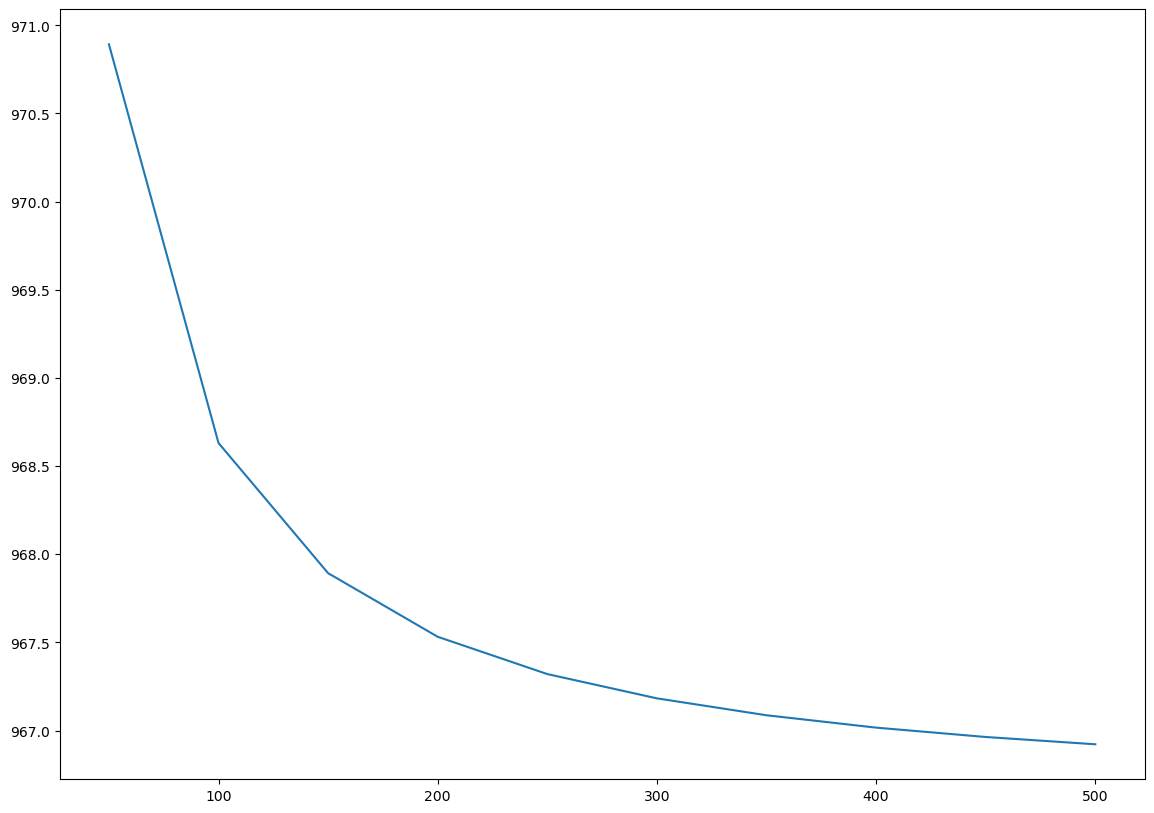

In [13]:
# plot estimated value against price steps
plt.figure(figsize=(14,10))
plt.plot(result_df['S_steps'], result_df['CN'], '-', markersize=3)
plt.savefig('CN_Value.png')
plt.show()

In [7]:
# sigma sensitivity
sigma_test = pd.DataFrame()
for sig in sigmas:
    sigma_test = pd.concat([sigma_test, pd.DataFrame.from_dict(CNFD(sig, 500, 501, 1))])
sigma_test.reset_index(inplace = True)
sigma_test.to_csv('Sigma_sensitivity.csv', index = False)
sigma_test

,index,S_steps,t_steps,CN,Barrier Lambda,Sigma
0,0,500,5174,973.969450,0.0,0.27405
1,0,500,5174,978.777812,0.0,0.26391
2,0,500,5174,979.845911,0.0,0.26169
3,0,500,5174,981.477914,0.0,0.25832
4,0,500,5174,980.929259,0.0,0.25945
5,0,500,5174,980.150031,0.0,0.26106
6,0,500,5174,980.488467,0.0,0.26036
7,0,500,5174,980.449761,0.0,0.26044
8,0,500,5174,980.619155,0.0,0.26009
9,0,500,5174,981.108749,0.0,0.25908


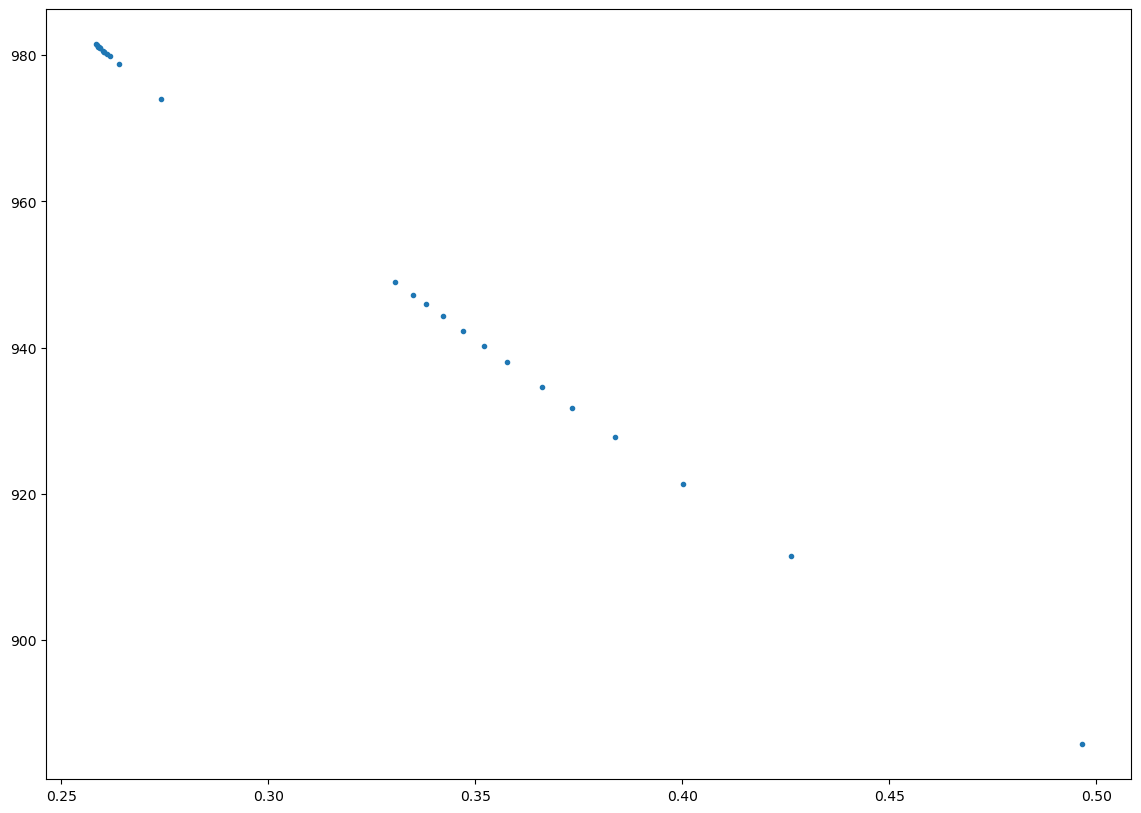

In [8]:
# plot sigma against estimated value
plt.figure(figsize=(14,10))
plt.plot(sigma_test['Sigma'], sigma_test['CN'], 'o', markersize=3)
plt.savefig('CN_sigma.png')
plt.show()

In [9]:
# calculate values if lambda oscillating between 0 and 0.5
SU = 3 * S0
result_3 = CNFD(sigma, 50, 501, 50)
result_3_df = pd.DataFrame.from_dict(result_3)
result_3_df

,S_steps,t_steps,CN,Barrier Lambda,Sigma
0,50,5174,977.960484,0.5,0.28936
1,100,5174,968.543381,0.0,0.28936
2,150,5174,969.927060,0.5,0.28936
3,200,5174,967.463361,0.0,0.28936
4,250,5174,968.419244,0.5,0.28936
5,300,5174,966.815771,0.0,0.28936
6,350,5174,967.969848,0.5,0.28936
7,400,5174,966.813952,0.0,0.28936
8,450,5174,967.418509,0.5,0.28936
9,500,5174,966.864542,0.0,0.28936


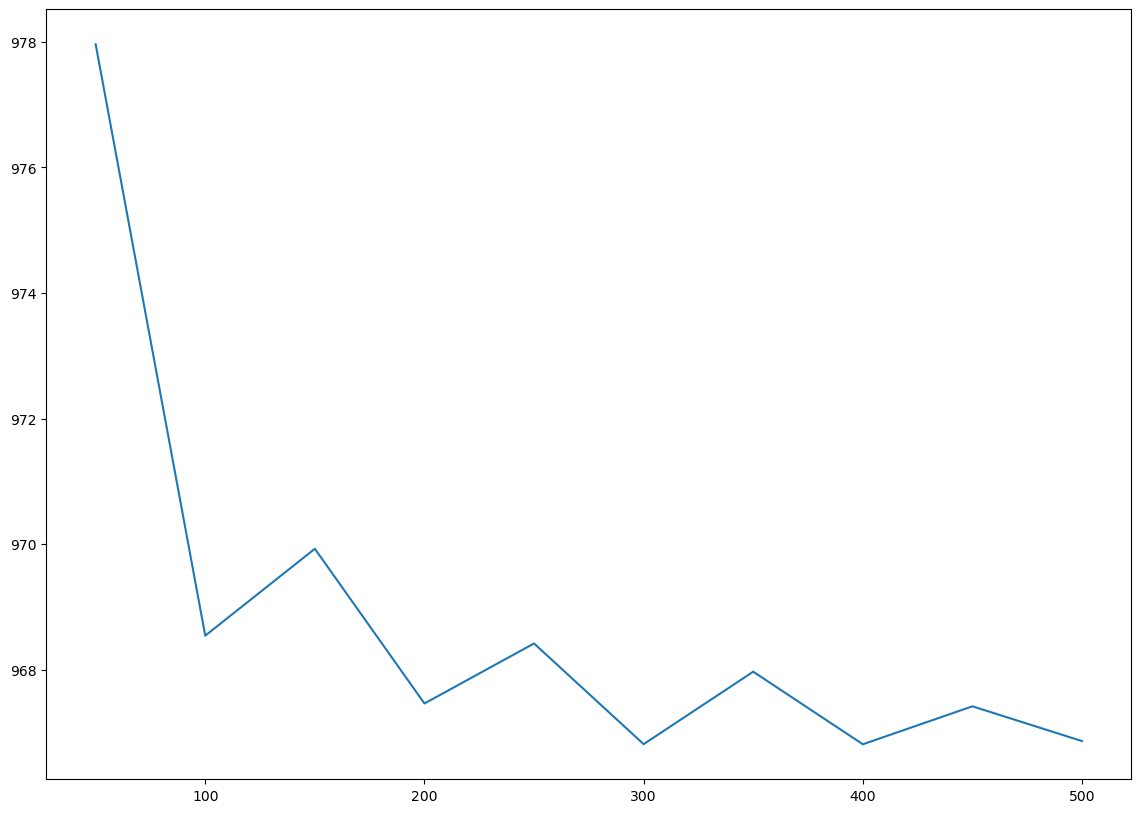

In [10]:
# plot non-linearity error
plt.figure(figsize=(14,10))
plt.plot(result_3_df['S_steps'], result_3_df['CN'], '-', markersize=3)
plt.savefig('CN_nonlinearity.png')
plt.show()